# arXiv Matplotlib Query

Anecdotally the Matplotlib maintainers were told 

*"About 15% of arXiv papers use Matplotlib"*

Unfortunately the original analysis of this data was lost.  We reproduce it here.

## Watermark

Starting in the early 2010s, Matplotlib started including the bytes `b"Matplotlib"` in every PNG and PDF that they produce.  These bytes persist in the output PDFs stored on arXiv.  As a result, it's pretty simple to check if a PDF contains a Matplotlib image.  All we have to do is scan through every PDF and look for these bytes; no parsing required.

## Data

The data is stored in a requester pays bucket at s3://arxiv (more information at https://arxiv.org/help/bulk_data_s3 ) and also on GCS hosted by Kaggle (more information at https://www.kaggle.com/datasets/Cornell-University/arxiv).  

The data is about 1TB in size.  We're going to use Dask for this.

## Create Dask Cluster

We start with a small Dask cluster on AWS in the same region where the data is stored.  We also mimic the local software environment on the cluster with `package_sync=True`.

In [42]:
import coiled

cluster = coiled.Cluster(
    name="arxiv",
    shutdown_on_close=False,
    package_sync=True, 
    backend_options={"region": "us-east-1"},
)

╭───────────────────────────────────────── Package Issues ─────────────────────────────────────────╮
│                    ╷                                                           ╷                 │
│   Package          │ Issue                                                     │ Risk Level      │
│ ╶──────────────────┼───────────────────────────────────────────────────────────┼───────────────╴ │
│   libgfortran5     │ 11.3.0 has no install candidate for linux-64              │                 │
│   libgfortran      │ 5.0.0 has no install candidate for linux-64               │                 │
│   grpcio           │ 1.48.1 has no install candidate for linux-64              │                 │
│   grpc-cpp         │ 1.48.1 has no install candidate for linux-64              │                 │
│   openssl          │ Package ignored                                           │                 │
│   libabseil        │ Package ignored                                           │                 │
│                    ╵                                                           ╵                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

In [43]:
from dask.distributed import Client, wait
client = Client(cluster)

### Get all filenames

In [44]:
import s3fs
s3 = s3fs.S3FileSystem(requester_pays=True)

directories = s3.ls("s3://arxiv/pdf")
len(directories)

5288

In [6]:
directories[1000]

'arxiv/pdf/arXiv_pdf_1407_009.tar'

## Process one file

Mostly we have to muck about with tar files.  This wasn't hard.  The `tarfile` library is in the stardard library.  It's not beautiful, but it's also not hard to use.

In [89]:
import tarfile
import io

def extract(filename):
    out = []
    with s3.open(filename) as f:
        bytes = f.read()
        with io.BytesIO() as bio:
            bio.write(bytes)
            bio.seek(0)
            with tarfile.TarFile(fileobj=bio) as tf:
                for member in tf.getmembers():
                    if member.isfile() and member.name.endswith(".pdf"):
                        data = tf.extractfile(member).read()
                        out.append((
                            member.name, 
                            b"matplotlib" in data.lower()
                        ))
            return out

In [91]:
# See an example of its use
extract(directories[20])[:10]

[('0011/cs0011019.pdf', False),
 ('0011/gr-qc0011017.pdf', False),
 ('0011/hep-ex0011095.pdf', False),
 ('0011/cond-mat0011373.pdf', False),
 ('0011/hep-ph0011035.pdf', False),
 ('0011/gr-qc0011082.pdf', False),
 ('0011/cond-mat0011202.pdf', False),
 ('0011/hep-ph0011209.pdf', False),
 ('0011/cond-mat0011038.pdf', False),
 ('0011/gr-qc0011014.pdf', False)]

# Scale function to full dataset

In [ ]:
cluster.scale(100)

In [64]:
futures = client.map(extract, directories)
wait(futures)

# We had one error in one file.  Let's just ignore and move on.
good = [future for future in futures if future.status == "finished"]

lists = client.gather(good)

In [ ]:
# Scale down now that we're done
cluster.scale(4)

In [75]:
# Convert to Pandas

dfs = [
    pd.DataFrame(list, columns=["filename", "has_matplotlib"]) 
    for list in lists
]

df = pd.concat(dfs)

df

## Enrich Data

Let's make a couple of functions to enhance our data a bit. 

In [85]:
def date(filename):
    year = int(filename.split("/")[0][:2])
    month = int(filename.split("/")[0][2:4])
    if year > 80:
        year = 1900 + year
    else:
        year = 2000 + year
    
    return pd.Timestamp(year=year, month=month, day=1)

date("0005/astro-ph0001322.pdf")

Timestamp('2000-05-01 00:00:00')

In [86]:
df["date"] = df.filename.map(date)
df.head()

,filename,has_matplotlib,date
0,0001/astro-ph0001477.pdf,False,2000-01-01
1,0001/hep-th0001095.pdf,False,2000-01-01
2,0001/astro-ph0001322.pdf,False,2000-01-01
3,0001/cond-mat0001159.pdf,False,2000-01-01
4,0001/astro-ph0001132.pdf,False,2000-01-01


## Plot

The scalable work is over.  Now we can just fool around with Pandas and Matplotlib.

<AxesSubplot: xlabel='date'>

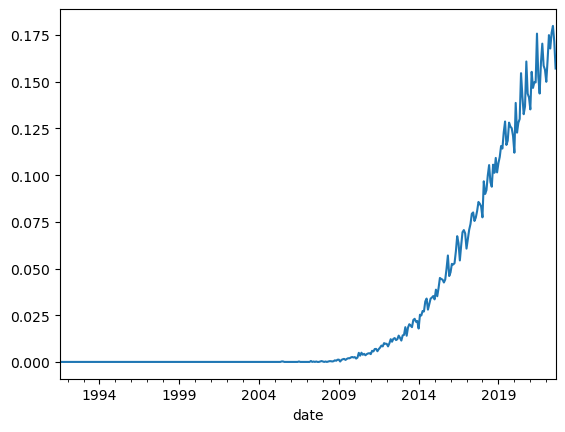

In [88]:
df.groupby("date").has_matplotlib.mean().plot()

Yup.  Matplotlib is used pretty commonly on arXiv.  Go team.

In [92]:
df.to_csv("arxiv-matpl

6320559